#### Reference
https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf

####  --- Theory ---  
To find parameters of Cox model or any other model we have to apply some optimization procedure. The way it is done very often is by maximizing likelihood function. First, we have to formalize it. 

Likelihood function for censored data is specific. 

We restrict ourselves to the case of right-censored data. Suppose that for each observation we have $t_{i}$. It can have two interpretations, either it is the time of the event or it is the last time we have seen the observation and the event has not yet occurred.

More formally:
- $t_{i}$, $d_{i}$ = 0 - the event hasn't yet occured, it occures at t > $t_{i}$ 
- $t_{i}$, $d_{i}$ = 1 - the event has occured at $t_{i}$ 

As a side note, people use different notation for indicator variable depending on whether they want to emphasize the fact of being censored or of being the event. For an observation you might have 1 following one convention and 0 following the another one.

No we can define likelihood function, which will be split into 2 parts: uncensored observations and censored observations. 
As a reminder, we define likelihood as follows: <br><br>
L = $\prod_{i=1}^{n}$f($x_{i}$| $\theta$) <br><br>
It turns out that logarithmic form is easier to maximize: <br> <br>
log(L) = $\sum_{i=1}^{n}$ log(f($x_{i}$| $\theta$)) <br>

Let's write contributions from each observations in a distinct way: <br><br>
log(L) = $\sum_{i=1}^{n}$ log($L_{i}$)

Now let's think about the contribution or the form of $L_{i}$ from the uncensored observation. In this case we know that the event happened at $t_{i}$, and we can simply maximize density at this point. So <br> <br> 
$L_{i}$ = f($t_{i}$), where f is the specific probability density function of waiting time. <br>I dropped for the time being $\theta$ from the notation. As such, from the previous notebook we know that f(t) = S(t)$\lambda$(t). 
<br><br>

As far as the censored observation are concerned, all we know is that they haven't happened at censored moment $t_{i}$. So we can only maximize: <br>
$L_{i}$ = S($t_{i}$). <br>

We can make use of our $d_{i}$ indicator and write jointly. <br><br>
log(L) = $\sum_{i=1}^{n}$$log(S(t_{i})\lambda(t_{i})^{d(t_{i})})$ = $\sum_{i=1}^{n}$[log(S($t_{i}$)) + d($t_{i}$)log($\lambda$($t_{i}$))] <br><br>

Remembering that: $S(t_{i}) = e^{-\Lambda(t_{i})}$ <br><br>
Finally, we have: <br><br>

log(L) = $\sum_{i=1}^{n}$[d($t_{i}$)log($\lambda$($t_{i}$)) - $\Lambda(t_{i})$]

####  --- Theory ---  
As a warm-up, we'll implement Cox model in tensorlow. Before doing so we have to make some decisions in order to get components that appear in log-likelihood function.<br>
In this model we'll assume some parametric model for hazard function $\lambda(t|X_{i})$. We can assume that $\lambda_{0}(t)$ is just some constant $\lambda$. 
So <br>
$\lambda(t|X_{i})$ = $\lambda e^{\beta^{T}X_{i}}$ <br>
Logarithm of it has an especially nice form (and this form is needed in log-likelihood function): <br> <br>
log($\lambda(t|X_{i})$) = log($\lambda$) + $\beta^{T}X_{i}$

We also need cumulative hazard function: <br> <br>
$\Lambda(t_{i})$ = $\int_{0}^{t_{i}}$$\lambda e^{\beta^{T}X_{i}}$dt, <br><br>it looks scary, but fortunately it doesn't depend on t, so we have: <br><br>
$\Lambda(t_{i})$ = $\lambda e^{\beta^{T}X_{i}}t_{i}$

Finally for our toy model we derived the following likelihood: <br><br>
log(L) = $\sum_{i=1}^{n}$[$d_{i}(\beta^{T}X_{i}$ + log($\lambda$)) - $\lambda e^{\beta^{T}X_{i}}t_{i}$]

In [2]:
%matplotlib inline
from collections import defaultdict
from operator import itemgetter

import keras
import keras.backend as K
from keras.models import Model
import keras.layers as L
from keras.utils.generic_utils import get_custom_objects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, StandardScaler
import tensorflow as tf
plt.style.use('ggplot')

####  --- Theory ---  
Before moving to WTTE-RNN model it might be useful to introduce Weibull distribution, the model to some extent relies on it.

Its support is [0, $\infty$] which is useful feature to have in the survival analysis. The Weibull distribution: <br>

$f(x) = \frac{a} {\lambda}(\frac{x}{\lambda})^{a-1}e^{-(x/\lambda)^a}$. 

As we can see it has 2 parameters to tweak: a and $\lambda$ (on wikipedia, k and $\lambda$) <br>
$\lambda$ is responsible for scale, and a is responsible for shape

let's take a look at couple of combinations (from wikipedia):

In [3]:
from scipy.stats import weibull_min

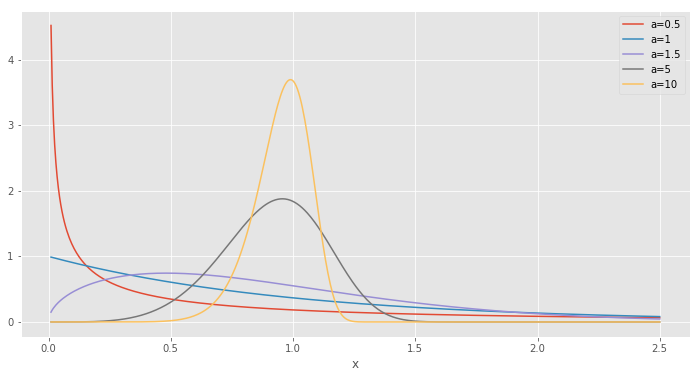

In [4]:
# in scipy implementation lambda is probably equal to 1
params = (0.5, 1, 1.5, 5, 10)
x = np.linspace(0.01, 2.5, num=500)
d = {}
for a in params:
    d["a={}".format(a)] = weibull_min.pdf(x, a)
d = pd.DataFrame(d)
d['x'] = x
d.set_index('x', inplace=True)
d.plot(figsize=(12, 6));

In [5]:
"""
It maybe not the main purpose of the following models but it can be interesting to see how they perform on standard 
regression task.

So we assess our models based on two metrics:
- mse error on validation set (where model is trained to predict a time to the second event)
- we assess by eye on a couple of example what it produces
""";

In [6]:
censored_df = pd.read_csv('data/censored_visitors_data.csv', dtype={'fullVisitorId': str})
visitors_data = pd.read_csv('data/visitors_data.csv', dtype={'fullVisitorId': str})

In [7]:
censored_df.head(1)

,fullVisitorId,first_visit,second_visit,duration,duration_day,censored,censored_durations
0,0000040862739425590,2017-02-11 18:09:31,2017-02-11 18:47:04,2253.0,0.026076,0,0.026076


In [8]:
visitors_data.head(1)

,fullVisitorId,channelGrouping,visitStartTime,totals_bounces,totals_hits,totals_pageviews,totals_transactionRevenue,device_browser,device_is_mobile,geo_network_city,geo_network_continent,traffic_source,visit_number
0,0000040862739425590,Paid Search,2017-02-11 18:09:31,0.0,2.0,2.0,0.0,Chrome,False,Oakland,Americas,google,1


In [9]:
# here we have data that characterizes first visit 
visitors_data_first = visitors_data[visitors_data['visit_number'] == 1]

In [10]:
class BinarizeCategory(TransformerMixin):
    def __init__(self, column: str, p: float):
        """
        parameters
        ----------
        column: we expect to have this column in df we transform
        p: proportion a class has to have to have distinct level
        the rest is combined to '<small_class>' level
        """
        self.column_ = column
        self.p_ = p
        self.lb_ = LabelBinarizer()
        self.map_ = None
    
    def fit(self, X):
        col = X[self.column_].copy()
        self.map_ = self._build_map(col, self.p_)
        self.lb_.fit(col.map(self.map_))
        return self
        
    def transform(self, X):
        return self.lb_.transform(X[self.column_].map(self.map_))
    
    def _build_map(self, col, p):
        n = len(col)
        freqs = col.value_counts() / n
        classes = freqs[freqs > p].index.values
        return defaultdict(lambda: '<small_class>', dict(zip(classes, classes)))

In [11]:
fs_columns = ['totals_bounces', 'totals_hits', 'totals_pageviews', 'totals_transactionRevenue',
             'channelGrouping', 'device_browser', 'device_is_mobile', 'geo_network_city', 'geo_network_continent', 
             'traffic_source']
labels_column = ['censored_durations', 'duration_day', 'censored']

In [12]:
censored_df = censored_df.merge(visitors_data_first, how='inner', on='fullVisitorId')

In [13]:
censored_df.shape

(50000, 19)

In [14]:
censored_df.head(1)

,fullVisitorId,first_visit,second_visit,duration,duration_day,censored,censored_durations,channelGrouping,visitStartTime,totals_bounces,totals_hits,totals_pageviews,totals_transactionRevenue,device_browser,device_is_mobile,geo_network_city,geo_network_continent,traffic_source,visit_number
0,0000040862739425590,2017-02-11 18:09:31,2017-02-11 18:47:04,2253.0,0.026076,0,0.026076,Paid Search,2017-02-11 18:09:31,0.0,2.0,2.0,0.0,Chrome,False,Oakland,Americas,google,1


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(censored_df[fs_columns], censored_df[labels_column], 
                                                     test_size=0.2, 
                                                     random_state=44, 
                                                     shuffle=True)

In [16]:
pipeline = make_union(
    BinarizeCategory('channelGrouping', 0.005), 
    BinarizeCategory('device_browser', 0.005), 
    BinarizeCategory('geo_network_city', 0.005), 
    BinarizeCategory('geo_network_continent', 0),
    BinarizeCategory('traffic_source', 0.05),
    make_pipeline(FunctionTransformer(itemgetter([
        'device_is_mobile', 
        'totals_bounces',
        'totals_hits',
        'totals_pageviews'
    ]), validate=False), StandardScaler()), 
    make_pipeline(
        FunctionTransformer(lambda x: np.log1p(itemgetter('totals_transactionRevenue')(x)).values.reshape(-1, 1), 
                            validate=False)
    )
)

In [17]:
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

In [18]:
ridge = Ridge()
rf = RandomForestRegressor()

In [19]:
# we assume that we see censored data in training set
# but on validation set we will assess the models on uncensored data
ridge.fit(X_train_transformed, y_train['censored_durations'])
rf.fit(X_train_transformed, y_train['censored_durations'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
y_pred_ridge = ridge.predict(X_valid_transformed)
y_pred_rf = rf.predict(X_valid_transformed)

In [21]:
mean_squared_error(y_valid['duration_day'], y_pred_ridge)

645.0251318033266

In [22]:
mean_squared_error(y_valid['duration_day'], y_pred_rf)

702.9477095578972

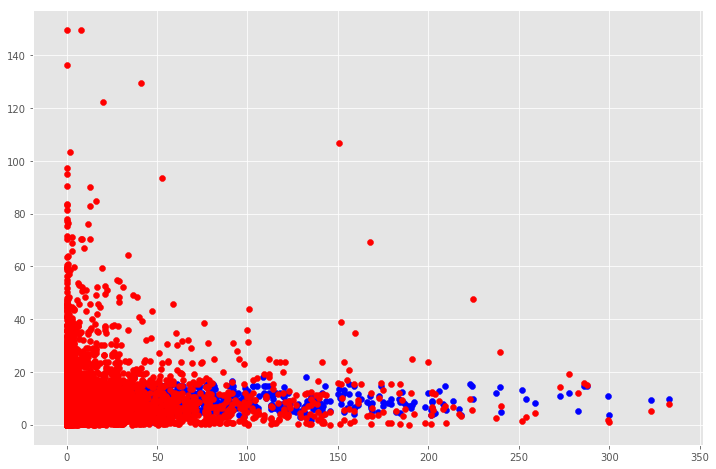

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(y_valid['duration_day'], y_pred_ridge, c='blue')
plt.scatter(y_valid['duration_day'], y_pred_rf, c='red');

####  --- Theory ---  
Now, we can slowly move to WTTE-RNN model. We begin by introducing cost function it optimizes. 

We have to say that there are two types of cost function, or likeliehood. One is derived for continuous Weibull distribution and the second one for its discrete variant. We start by discussing continuous version, because discrete one suggests using recurrent neural network and I think it is instructive to start from something simpler.

As a reminder, our derived log-likelihood function <br> <br>
log(L) = $\sum_{i=1}^{n}$[d($t_{i}$)log($\lambda$($t_{i}$)) - $\Lambda(t_{i})$]

In the original thesis, Weibull distribution models distribution function. And as we know from distribution function we can get to hazard function and cumulative distribution function. The calculations will be here omitted:


$\Lambda(t)$ = $(\frac{t}{\alpha})^{\beta}$ <br><br>
$\lambda(t)$ = $(\frac{t}{\alpha})^{\beta - 1}\frac{\beta}{\alpha}$=$\frac{t^{\beta - 1}\beta}{\alpha^{\beta}}$

We can plug these quantities into log-likelihood formula <br><br>
log(L) = $\sum_{i=1}^{n}d(t_{i})[\beta log(\frac{t}{\alpha}) + log(\beta) - log(t)] - (\frac{t}{\alpha})^{\beta}$

Having this loss we'll reimplement ridge regression model and use some more complicated model to see whether we can gain something useful just using the loss function, which was created specially for this kind of data.

In [24]:
def alpha_beta(x):
    return tf.concat(
        [   tf.reshape(K.exp(x[:, 0]), [-1, 1]),
            tf.reshape(K.softplus(x[:, 1]), [-1, 1])
        ], axis=1)

In [25]:
get_custom_objects().update({'alpha_beta': 
                             L.Activation(alpha_beta)})

In [26]:
def create_model(n_fs):
    input_ = L.Input(shape=(n_fs, ))
    l1 = L.Dense(64, 
                activation='relu')(input_)
    l2 = L.Dense(2, 
                  activation='linear')(l1)
    output_ = L.Activation(alpha_beta)(l2)
    return Model(inputs=input_, outputs=output_)

In [27]:
model = create_model(X_train_transformed.shape[1])

log(L) = $\sum_{i=1}^{n}d(t_{i})[\beta log(\frac{t}{\alpha}) + log(\beta) - log(t)] - (\frac{t}{\alpha})^{\beta}$


first_part = $d(t_{i})[\beta log(\frac{t}{\alpha}) + log(\beta) - log(t)]$<br>
second_part = $(\frac{t}{\alpha})^{\beta}$

In [28]:
def censored_loss(y_true, y_pred):
    """
    parameters
    ----------
    y_true: 3-dim array, (censored times, observed mask, .)
    y_pred: 2-dim array, (alphas, betas)
    """
    first_part = y_true[:, 1] * (y_pred[:, 1] * K.log(y_true[:, 0] / y_pred[:, 0]) + K.log(y_pred[:, 1]) - K.log(y_true[:, 0]))
    second_part = K.pow(y_true[:, 0] / y_pred[:, 0], y_pred[:, 1])
    
    return -K.mean(first_part - second_part)

In [35]:
"""
As our model returns parameters of Weibull distribution and we want
to have a rough estimation how well it fits to the data, we take 
a median of the predicted distribution and compare it to the ground truth
""";

In [29]:
def custom_mse(y_true, y_pred):
    """
    parameters
    ----------
    y_true: 3-dim array, only last dim is used (., ., uncensored times)
    y_pred: 2-dim array, (alphas, betas)
    """
    return K.mean(K.pow(y_true[:, 2] - y_pred[:, 0] * K.pow(np.log(2).astype(np.float32), y_pred[:, 1]), 2))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 47)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3072      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 3,202
Trainable params: 3,202
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(
    keras.optimizers.RMSprop(lr=1e-04),
    loss=censored_loss,
    metrics=[custom_mse]
)

In [32]:
y_train.head(1)

,censored_durations,duration_day,censored
32068,0.040336,0.040336,0


In [33]:
y_train['observed'] = 1 - y_train['censored']
y_valid['observed'] = 1 - y_valid['censored']

In [34]:
model.fit(
    X_train_transformed, 
    y_train[['censored_durations', 'observed', 'duration_day']],
    batch_size=32, 
    epochs=10,
    validation_data=(X_valid_transformed,
                    y_valid[['censored_durations', 
                             'observed', 'duration_day']])
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 82us/step - loss: 517462764604.8539 - custom_mse: 758.7657 - val_loss: 319.6250 - val_custom_mse: 731.1772
Epoch 2/10
40000/40000 [==============================] - 2s 60us/step - loss: 3.1678 - custom_mse: 715.9007 - val_loss: 1.3743 - val_custom_mse: 656.5976
Epoch 3/10
40000/40000 [==============================] - 2s 60us/step - loss: 1.3430 - custom_mse: 669.0395 - val_loss: 1.3552 - val_custom_mse: 649.7471
Epoch 4/10
40000/40000 [==============================] - 2s 61us/step - loss: 1.3352 - custom_mse: 671.6466 - val_loss: 1.3519 - val_custom_mse: 646.1951
Epoch 5/10
40000/40000 [==============================] - 2s 61us/step - loss: 1.3324 - custom_mse: 669.6845 - val_loss: 1.3502 - val_custom_mse: 646.1771
Epoch 6/10
40000/40000 [==============================] - 2s 60us/step - loss: 1.3306 - custom_mse: 691.4101 - val_loss: 1.3501 - val_custom_mse: 643.5630
Epoch 7

In [36]:
def take_median(y_pred):
    return y_pred[:, 0] * np.log(2) ** y_pred[:, 1]

In [40]:
y_pred_median = take_median(model.predict(X_valid_transformed))

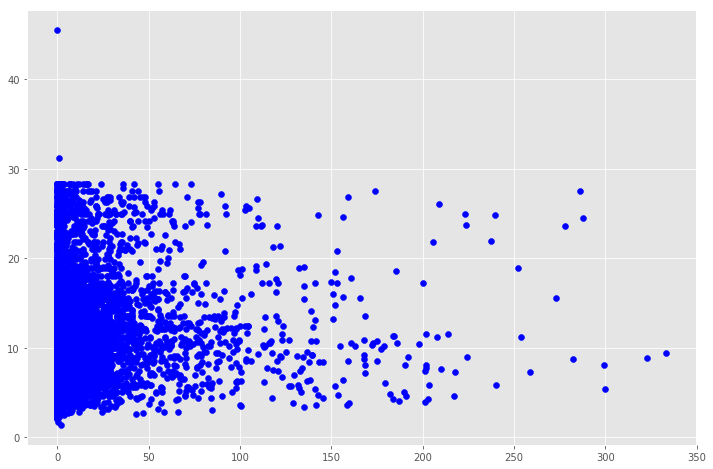

In [41]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(y_valid['duration_day'], y_pred_median, c='blue')

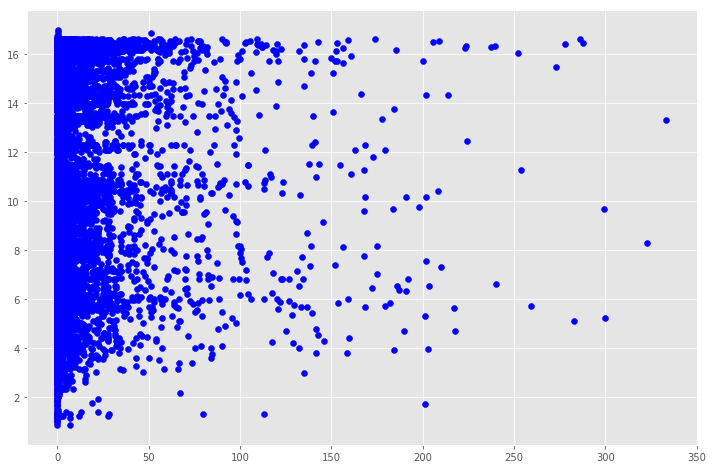

In [206]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(y_valid['duration_day'], y_pred_model, c='blue')

In [42]:
y_valid.head(2)

,censored_durations,duration_day,censored,observed
49457,3.746204,4.731551,1,0
20706,0.537254,1.105984,1,0


In [43]:
model.predict(X_valid_transformed[:2])

array([[17.73708   ,  0.37409347],
       [22.68191   ,  0.56658065]], dtype=float32)

In [44]:
def weibull(x, alpha, beta):
    return beta / alpha * (x / alpha) ** (beta - 1) * np.exp(-(x / alpha) ** beta)

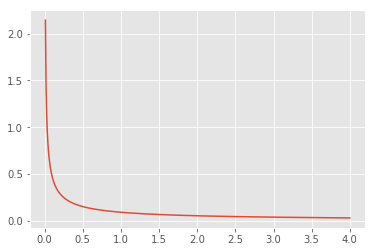

In [45]:
# true value 4.731551
beta = 0.37409347
alpha = 17.73708
x = np.linspace(0.01, 4, num=500)
y = weibull(x, alpha, beta)
plt.plot(x, y);

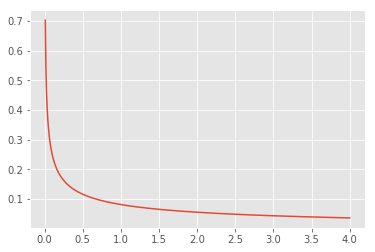

In [46]:
# true value 1.105984
beta = 0.56658065
alpha = 22.68191
x = np.linspace(0.01, 4, num=500)
y = weibull(x, alpha, beta)
plt.plot(x, y);